In [35]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.sparse import coo_matrix 
from qutip import *

%matplotlib inline

In [96]:
# functions to calculate parameters
def A(ra, g, gamma):
    return 2 * ra * g**2 / gamma**2

def B(g, gamma, fA):
    return 4 * fA * g**2 / gamma**2

def BdA(g, gamma):
    return 4 * g**2 / gamma**2

def M(n, m, fBdA):
    return 0.5 * (n + m + 2) + (n - m)**2 * fBdA / 8

def N(n, m, fBdA):
    return 0.5 * (n + m + 2) + (n - m)**2 * fBdA / 16

def n_p(fA, fB, kappa):
    return fA * (fA - kappa) / kappa / fB

In [157]:
# ordinary differential equation for diagonal terms only
def pn_dot(pn, t):
    pn_new = np.zeros(N_max)
    for n in xrange(N_max):
        pn_new[n] += (- (n + 1) * fA / (1 + (n + 1) * fBdA)  - kappa * n) * pn[n]
        if n > 0:
            pn_new[n] += n * fA / (1 + n * fBdA) * pn[n - 1]
        if n < N_max - 1:
            pn_new[n] += kappa * (n + 1) * pn[n + 1]
    return pn_new

In [287]:
# coefficients of the differential equation
def fnm(n, m, fA, fBdA, kappa):
    return - (M(n, m, fBdA) * fA / (1 + N(n, m, fBdA) * fBdA)) - 0.5 * kappa * (n + m)

def gnm(n, m, fA, fBdA):
    return np.sqrt(n * m) * fA / (1 + N (n - 1, m - 1, fBdA) * fBdA)

def hnm(n, m, kappa):
    return kappa * np.sqrt((n + 1) * (m + 1))

In [304]:
# differential equation for the whole density matrix
def rho_nm_dot(rho_nm, t):
    rho = rho_nm.reshape(N_max, N_max)
    rho_new = np.zeros([N_max, N_max])
    
    ij = range(N_max)
    for i in ij:
        for j in ij:
            rho_new[i, j] += FNM[i, j] * rho[i, j]
            if i > 0 and j > 0:
                rho_new[i, j] += GNM[i, j] * rho[i - 1, j - 1]
            if i < N_max - 1 and j < N_max - 1:
                rho_new[i, j] += HNM[i, j] * rho[i + 1, j + 1]
    
    return rho_new.reshape(-1)

## 11.1 Equation of Motion for the Density Matrix of the Cavity Field 

For $\rho_{nm}$, we have

$$
\begin{aligned}
\dot{\rho}_{nm} =
&- \frac{M_{nm}A}{1 + N_{nm}B/A} \rho_{nm} + \frac{\sqrt{nm}A}{1 + N_{n-1,m-1}B/A} \rho_{n-1,m-1} \\
&- \frac{C}{2}(n+m)\rho_{nm} + C\sqrt{(n+1)(m+1)} \rho_{n+1, m+1}
\end{aligned}
$$

where
$$
\begin{aligned}
A &= \frac{2r_a g^2}{\gamma^2},\\
B &= \frac{4g^2}{\gamma^2} A,\\
M_{nm} &= \frac{1}{2}(n+m+2) + (n-m)^2\frac{B}{8A},\\
N_{nm} &= \frac{1}{2}(n+m+2) + (n-m)^2\frac{B}{16A}.
\end{aligned}
$$

In particular, for diagonal elements, we have

$$
\begin{aligned}
\dot{p}(n) =
&- \frac{(n+1)A}{1 + (n+1)B/A} p(n) + \frac{nA}{1 + nB/A} p(n-1) \\
&- Cnp(n) + C(n+1)p(n+1)
\end{aligned}
$$

## 11.2 Photon Statistics

### 11.2.1 Linear approximation ($B = 0 $)

In the steady state ($\dot{p}(n)=0$), the equation of motion reduces to

$$
-A(n+1)p(n) + Anp(n-1) - C np(n) + C(n+1)p(n+1) = 0
$$

The detailed balance condition implies that

$$
\begin{aligned}
Anp(n-1) &- C np(n) = 0\\
A(n+1)p(n) &- C(n+1)p(n+1) = 0
\end{aligned}
$$

The solution is clearly

$$
p(n) = \left(1 - \frac{A}{C} \right) \left( \frac{A}{C} \right)^n, ~~~ A < C. 
$$

By defining an effective temperature $T$ by

$$
\exp\left( - \frac{\hbar \nu}{k_B T} \right) = \frac{A}{C},
$$

we could obtain

$$
p(n) = \left[1 - \exp\left(-\frac{\hbar\nu}{k_B T}\right) \right] \exp\left(-\frac{n\hbar\nu}{k_B T} \right).
$$

So below the threshold, the steady-state solution is essentially that of a black-body cavity.

**A numerical example**

As $B = \frac{4g^2}{\gamma^2} A \to 0$, the interaction strenght must be much smaller than the atom decay rate, i.e. $g \ll \gamma$. Another condition should be satisfied is $A < C$. Let's choose the following parameters.

- Cavity frequency: $\omega_c = 2\pi$
- Atom frequency: $\omega_a = 2\pi$
- Coupling strength: $g = 0.0001 \times 2\pi$
- atom dissipation rate: $\gamma = 0.01$
- cavity dissipation rate: $C = 0.01$
- atom pump rate: $r_a = 0.50$
- average thermal photon: $n_{\rm th} = 0$

In [348]:
# linear approximation parameters
w_c = 2.0 * np.pi
w_a = 2.0 * np.pi
g = 0.0001 * 2 * np.pi

gamma = 0.01
kappa = 0.01
ra = 0.9

N_max = 25

fA = A(ra, g, gamma)
fB = B(g, gamma, fA)
fBdA = BdA(g, gamma)

# aver_n = n_p(fA, fB, kappa)

In [349]:
fA, fB, kappa, fA/kappa

(0.007106115168784337, 0.00011221527287117076, 0.01, 0.7106115168784337)

In [350]:
1 / w_a

0.15915494309189535

In [351]:
t_list = 0.05 * 2 * np.pi / w_c * np.arange(40000)
pn_0 = np.zeros(N_max)
pn_0[0] = 1

%time result1 = odeint(pn_dot, pn_0, t_list)

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 51.2 ms


In [352]:
n_list = np.arange(N_max)
aver_n = [sum(vec * n_list) for vec in result1]

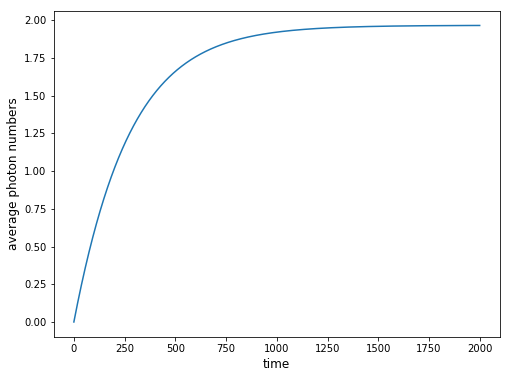

In [353]:
plt.figure(figsize=(8,4))
plt.plot(t_list, aver_n)
plt.xlabel("time", fontsize=12)
plt.ylabel("average photon numbers", fontsize=12)

In [354]:
ratio = fA/kappa
n_list = np.arange(N_max)
pn_list = [(1 - ratio) * ratio ** n for n in n_list]

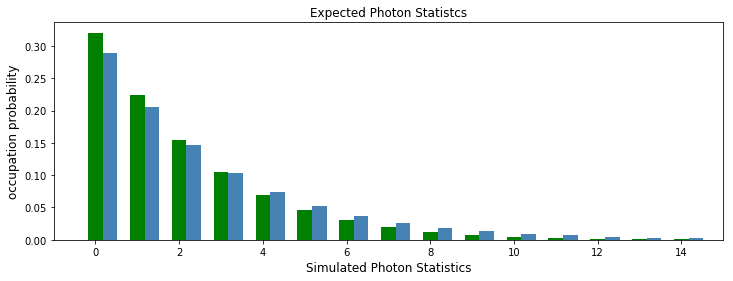

In [358]:
fig, ax = plt.subplots(figsize=(12,4))

w = 0.35
ax.bar(n_list, result1[-1], color="Green", width=w)
ax.bar(n_list + w, pn_list, color="SteelBlue", width=w)
plt.xlabel("Simulated Photon Statistics", fontsize=12)
plt.ylabel("occupation probability", fontsize=12)
plt.title("Expected Photon Statistcs")
plt.xlim(-1, 15);

### 11.2.2 Far above threshold ($A \gg C$)

In the steady state ($\dot{p}(n)=0$), the equation of motion reduces to

$$
-\frac{A^2}{B}p(n) + \frac{A^2}{B}p(n-1) - C np(n) + C(n+1)p(n+1) = 0.
$$

Detailed balance condition is

$$
\frac{A^2}{B} p(n-1) - C n p(n) = 0
$$

The normalized solution of these euqaitons is 

$$
p(n) = e^{- \langle n \rangle} \frac{- \langle n \rangle ^ n}{n!},
$$

with

$$
\langle n \rangle = \frac{A^2}{BC}.
$$

Thus the photon statistics of the lasre far above threshold are given by a Poisson distribution which is a characteristic of a coherent state.

**A numerical example**

As $A \gg C$. Let's choose the following parameters.

- Cavity frequency: $\omega_c = 2\pi$
- Atom frequency: $\omega_a = 2\pi$
- Coupling strength: $g = 0.01 \times 2\pi$
- atom dissipation rate: $\gamma = 0.01$
- cavity dissipation rate: $C = 0.01$
- atom pump rate: $r_a = 0.50$
- average thermal photon: $n_{\rm th} = 0$

In [359]:
# linear approximation parameters
w_c = 2.0 * np.pi
w_a = 2.0 * np.pi
g = 0.01 * 2 * np.pi

gamma = 0.01
kappa = 0.01
ra = 0.4

N_max = 60

fA = A(ra, g, gamma)
fB = B(g, gamma, fA)
fBdA = BdA(g, gamma)

aver_n = n_p(fA, fB, kappa)

In [360]:
fA, fB, kappa, fA/kappa, aver_n

(31.58273408348595,
 4987.345460940925,
 0.01,
 3158.273408348595,
 19.993667426022355)

In [361]:
t_list = 0.02 * 2 * np.pi / w_c * np.arange(40000)
pn_0 = np.zeros(N_max)
pn_0[0] = 1

%time result2 = odeint(pn_dot, pn_0, t_list)

CPU times: user 156 ms, sys: 4 ms, total: 160 ms
Wall time: 161 ms


In [362]:
n_list = np.arange(N_max)
aver_n = [sum(vec * n_list) for vec in result2]

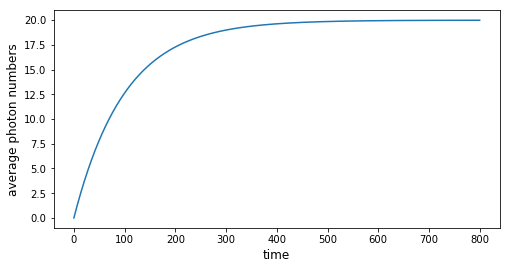

In [364]:
plt.figure(figsize=(8,4))
plt.plot(t_list, aver_n)
plt.xlabel("time", fontsize=12)
plt.ylabel("average photon numbers", fontsize=12)

In [365]:
ne = fA**2/kappa/fB
n_list = np.arange(N_max)
pn_list = [np.exp(-ne) * ne**n / np.math.factorial(n) for n in n_list]

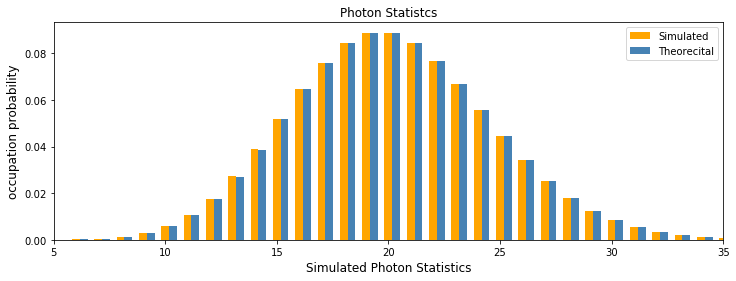

In [369]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(n_list, result2[-1], color="Orange", width=0.35, label="Simulated")
ax.bar(n_list + 0.35, pn_list, color="Steelblue", width=0.35, label="Theorecital")
plt.xlabel("Simulated Photon Statistics", fontsize=12)
plt.ylabel("occupation probability", fontsize=12)
plt.title("Photon Statistcs")
plt.legend()
plt.xlim(5, 35);

### 2. initial state: coherent state

In [ ]:
# parameters in the differential equation
ij = range(N_max)
FNM = np.array([fnm(i, j, fA, fBdA, kappa) for i in ij for j in ij]).reshape(N_max, N_max)
GNM = np.array([gnm(i, j, fA, fBdA) for i in ij for j in ij]).reshape(N_max, N_max)
HNM = np.array([hnm(i, j, kappa) for i in ij for j in ij]).reshape(N_max, N_max)

In [79]:
t_list = np.linspace(0, 400, 1601)
rho_0 = coherent_dm(N_max, 1)
rho_0 = np.real(coo_matrix(rho_0.data).toarray().reshape(-1))

In [80]:
%time result3 = odeint(rho_nm_dot, rho_0, t_list)

CPU times: user 8min 27s, sys: 560 ms, total: 8min 27s
Wall time: 7min 47s


In [81]:
result3_rho = [Qobj(vec.reshape(N_max, N_max)) for vec in result3]

In [83]:
num_op = num(N_max)
aver_n = [expect(num_op, rho) for rho in result3_rho]

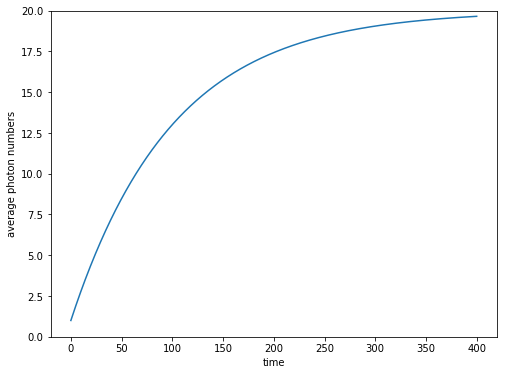

In [95]:
plt.figure(figsize=(8,6))
plt.plot(t_list, aver_n)
plt.ylim(0, 20)
plt.xlabel("time")
plt.ylabel("average photon numbers")

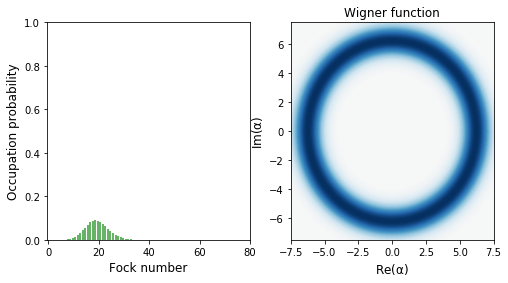

In [88]:
plot_wigner_fock_distribution(result3_rho[1600]);